In [1]:
import numpy as np

import ppsci
from ppsci.utils import config
from ppsci.utils import logger

# set random seed for reproducibility
ppsci.utils.misc.set_random_seed(42)
# set training hyper-parameters
EPOCHS = 1000
ITERS_PER_EPOCH = 1
EVAL_FREQ = 200

# set output directory
OUTPUT_DIR = "./output_laplace2d"
logger.init_logger("ppsci", f"{OUTPUT_DIR}/train.log", "info")


W1009 11:19:24.639190 50543 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.7, Runtime API Version: 11.7
W1009 11:19:24.639899 50543 gpu_resources.cc:149] device: 0, cuDNN Version: 8.9.


In [2]:
# set model
model = ppsci.arch.MLP(("x", "y"), ("u",), 9, 20)

In [3]:
# set equation
equation = {"2dheat": ppsci.equation.Laplace(dim=2)}

In [4]:
# set geometry
geom = {"rect": ppsci.geometry.Rectangle((-1.0, -1.0), (1.0, 1.0))}

In [5]:
# 设置BC点数
NPOINT_INTERIOR = 99**2
NPOINT_PER_BC = 25
NPOINT_BC = NPOINT_PER_BC * 4
NPOINT_TOTAL = NPOINT_INTERIOR + NPOINT_BC

In [6]:
# set train dataloader config
train_dataloader_cfg = {
    "dataset": "IterableNamedArrayDataset",
    "iters_per_epoch": ITERS_PER_EPOCH,
}

In [7]:
# 设置PDE约束
pde_constraint = ppsci.constraint.InteriorConstraint(
    equation["2dheat"].equations,
    {"laplace": 0},
    geom["rect"],
    {**train_dataloader_cfg, "batch_size": NPOINT_INTERIOR},
    ppsci.loss.MSELoss("mean"),
    weight_dict={
            "laplace": 1,
    },
    evenly=True,
    name="EQ",
)

In [8]:
# compute ground truth function
def u_top_bc(out):
    x, y = out["x"], out["y"]
    return 0

def u_bottom_bc(out):
    x, y = out["x"], out["y"]
    return 50/75

def u_left_bc(out):
    x, y = out["x"], out["y"]
    return 75/75

def u_right_bc(out):
    x, y = out["x"], out["y"]
    return 0

In [9]:
# 设置边界约束
bc_top = ppsci.constraint.BoundaryConstraint(
    {"u": lambda out: out["u"]},
    {"u": u_top_bc},
    geom["rect"],
    {**train_dataloader_cfg, "batch_size": NPOINT_PER_BC},
    ppsci.loss.MSELoss("mean"),
    weight_dict={
        "u": 0.25,
    },
    criteria=lambda x, y: np.isclose(y, 1),
    name="BC_top",
)
bc_bottom = ppsci.constraint.BoundaryConstraint(
    {"u": lambda out: out["u"]},
    {"u": u_bottom_bc},
    geom["rect"],
    {**train_dataloader_cfg, "batch_size": NPOINT_PER_BC},
    ppsci.loss.MSELoss("mean"),
    weight_dict={
        "u": 0.25,
    },
    criteria=lambda x, y: np.isclose(y, -1),
    name="BC_bottom",
)
bc_left = ppsci.constraint.BoundaryConstraint(
    {"u": lambda out: out["u"]},
    {"u": u_left_bc},
    geom["rect"],
    {**train_dataloader_cfg, "batch_size": NPOINT_PER_BC},
    ppsci.loss.MSELoss("mean"),
    weight_dict={
        "u": 0.25,
    },
    criteria=lambda x, y: np.isclose(x, -1),
    name="BC_left",
)
bc_right = ppsci.constraint.BoundaryConstraint(
    {"u": lambda out: out["u"]},
    {"u": u_right_bc},
    geom["rect"],
    {**train_dataloader_cfg, "batch_size": NPOINT_PER_BC},
    ppsci.loss.MSELoss("mean"),
    weight_dict={
        "u": 0.25,
    },
    criteria=lambda x, y: np.isclose(x, 1),
    name="BC_right",
)

In [10]:
# wrap constraints together
constraint = {
    pde_constraint.name: pde_constraint,
    bc_top.name: bc_top,
    bc_bottom.name: bc_bottom,
    bc_left.name: bc_left,
    bc_right.name: bc_right,
}

In [11]:
# set optimizer
optimizer = ppsci.optimizer.Adam(learning_rate=5e-4)(model)

In [12]:
# initialize solver
solver = ppsci.solver.Solver(
    model,
    constraint,
    OUTPUT_DIR,
    optimizer,
    epochs=EPOCHS,
    iters_per_epoch=ITERS_PER_EPOCH,
    equation=equation,
    geom=geom
)

[2023/10/09 11:19:27] ppsci INFO: Using paddlepaddle 2.5.1 on device Place(gpu:0)
[2023/10/09 11:19:27] ppsci INFO: Set to_static=False for forward computation.


In [13]:
# train model
solver.train()

[2023/10/09 11:19:27] ppsci INFO: [Train][Epoch 1/1000][Iter: 1/1] lr: 0.00050000, loss: 0.53150, EQ: 0.03803, BC_top: 0.00344, BC_bottom: 0.12381, BC_left: 0.35608, BC_right: 0.01014, batch_cost: 0.54662s, reader_cost: 0.00002s, ips: 18113.07985 samples/s, eta: 0:09:06
[2023/10/09 11:19:27] ppsci INFO: [Train][Epoch 1/1000][Avg] loss: 0.53150, EQ: 0.03803, BC_top: 0.00344, BC_bottom: 0.12381, BC_left: 0.35608, BC_right: 0.01014
[2023/10/09 11:19:27] ppsci INFO: Finish saving checkpoint to ./output_laplace2d/checkpoints/latest
[2023/10/09 11:19:27] ppsci INFO: [Train][Epoch 2/1000][Iter: 1/1] lr: 0.00050000, loss: 0.47089, EQ: 0.02095, BC_top: 0.00224, BC_bottom: 0.11287, BC_left: 0.32722, BC_right: 0.00760, batch_cost: 0.28000s, reader_cost: 0.00002s, ips: 35361.08968 samples/s, eta: 0:04:39
[2023/10/09 11:19:27] ppsci INFO: [Train][Epoch 2/1000][Avg] loss: 0.47089, EQ: 0.02095, BC_top: 0.00224, BC_bottom: 0.11287, BC_left: 0.32722, BC_right: 0.00760
[2023/10/09 11:19:27] ppsci INFO: 

In [14]:
# 推理
n = 100
input_data = geom["rect"].sample_interior(n**2, evenly=True)
pinn_output = solver.predict(input_data)["u"].numpy().reshape(n,n)

In [15]:
# 实现FDM
import time
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}
B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
#computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 9.093



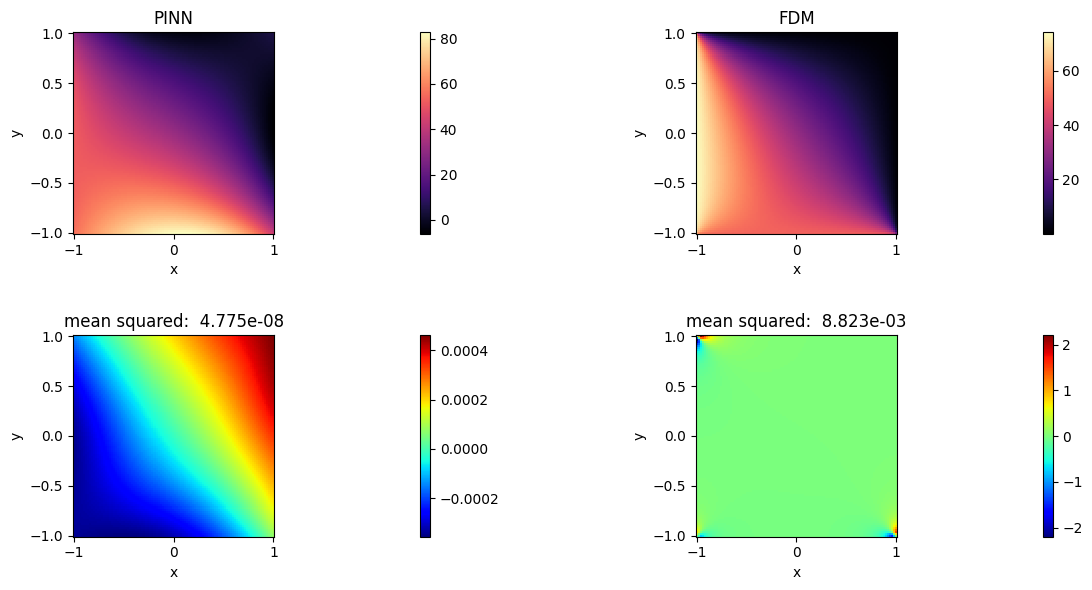

In [17]:
### 绘图
from matplotlib import pyplot as plt
plt.figure("", figsize=(12, 6))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])

S = pinn_output
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(222)
plt.pcolormesh(x, y, T, cmap="magma")
plt.colorbar()
plt.title(r"FDM")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
plt.show()